In [1]:
from netCDF4 import Dataset
from scipy.io          import netcdf
from scipy.integrate   import simps
from numpy             import roll

import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
from boutdata import collect

from Analysis import Analyse
from matplotlib.pyplot        import axis, savefig, pcolormesh, imshow, show, figure, subplot, title, plot, colorbar

In [2]:
File_name = '../FELTOR-model/output.nc'
Data = Dataset(File_name)
print(Data)

# plt.imshow(nc['Temp'][1,:,0,:])
# plt.show()
feltor_input = json.loads(Data.inputfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    inputfile: {
   "Nx" : 120,
   "Nx_out" : 60,
   "Ny" : 120,
   "Ny_out" : 60,
   "amplitude" : 0.5,
   "bc_x" : "DIR",
   "bc_y" : "DIR",
   "cols" : 2,
   "curvature" : 0.014999999999999999,
   "dt" : 0.10000000000000001,
   "eps_pol" : 9.9999999999999995e-07,
   "eps_time" : 1e-10,
   "height" : 500,
   "itstp" : 10,
   "lx" : 200,
   "ly" : 200,
   "maxout" : 800,
   "n" : 3,
   "n_out" : 3,
   "nu_perp" : 0.0050000000000000001,
   "posX" : 0.5,
   "posY" : 0.5,
   "rows" : 1,
   "sigma" : 10,
   "stages" : 3,
   "width" : 1000
}

    dimensions(sizes): x(180), y(180), time(801), energy_time(8001)
    variables(dimensions): float64 x(x), float64 y(y), float64 time(time), float64 electrons(time,y,x), float64 ions(time,y,x), float64 potential(time,y,x), float64 vorticity(time,y,x), float64 energy_time(energy_time), float64 mass(energy_time), float64 mass_diss(energy_time), float64 entropy(energy

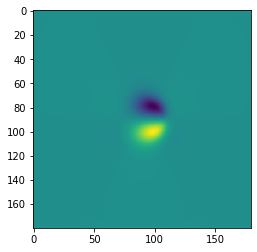

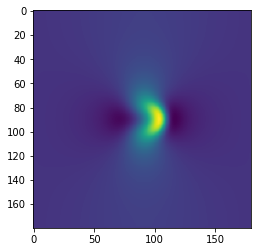

In [3]:
# print(nc['ions'][1, :, :])


## Plot with the grid
imshow(Data['vorticity'][100, :, :]);
show()

imshow(Data['ions'][100, :, :]);
show()

In [4]:
# X_mat = tile(Analitics.x.reshape(Analitics.Nx, 1), Analitics.Ny)
# Y_mat = tile(Analitics.y.reshape(Analitics.Ny, 1), Analitics.Nx).transpose()


# imshow(X_mat)

## Center of Mass

In [5]:
from numpy import tile, arange, array, copy

In [6]:
x    = array(Data['x'][:])
Nx   = len(x)

y    = array(Data['y'][:])
Ny   = len(y)
particles = array(Data['ions'][:])


def CM(x, y, n):
    
    x_vec, y_vec = copy(x), copy(y)
    
    Nx, Ny = len(x_vec), len(y_vec)
    
    X_mat = tile(x_vec.reshape(Nx, 1), Ny)
    Y_mat = tile(y_vec.reshape(Ny, 1), Nx).transpose()
        
    X_CM, Y_CM   = np.sum(X_mat * n, axis = (1,2)), np.sum(Y_mat * n, axis = (1,2))
    n_total = np.sum(n, axis = (1,2))
    
    return X_CM / n_total, Y_CM / n_total

X_CM, Y_CM = CM(x, y, particles)


### Velocity

In [7]:
def V_CM(X, Y, t):
    
    D_x, D_y, D_t = X - roll(X, 1), Y - roll(Y, 1), t - roll(t, 1)
    V_x, V_y      = D_x / D_t, D_y / D_t
    V_x[0] = V_y[0] = 0
    
    return V_x, V_y

V_CM_x, V_CM_y = V_CM(X_CM, Y_CM, array(Data['time'][:]))

## Integrate

In [8]:
from scipy.integrate   import simps

In [9]:
# print(Analitics.Data['mass'][:])
# print(Analitics.integrate('ions'))

In [10]:

x    = array(Data['x'][:])
Nx   = len(x)

y    = array(Data['y'][:])
Ny   = len(y)
mass = array(Data['ions'][:])

Integral = simps(mass, x, axis = 1)
Integral = simps(Integral, y, axis = 1)

# print(Integral)

## Analysis class

In [11]:
%timeit Analitics = Analyse('../FELTOR-model/output.nc')
Analitics = Analyse('../FELTOR-model/output.nc')
%timeit Mass = Analitics.integrate('ions')
Mass = Analitics.integrate('ions')
Potential = Analitics.integrate('potential')

531 ms ± 60.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
809 ms ± 5.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


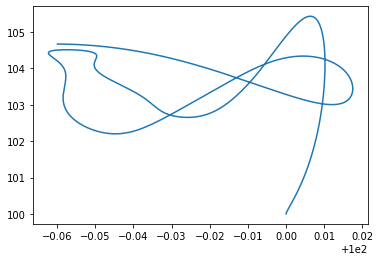

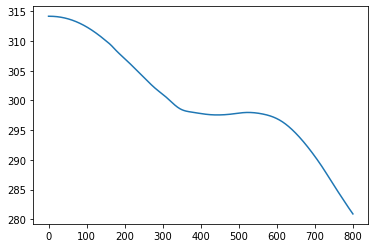

In [12]:
Analitics.plot_parameter(Analitics.Y_CM, Analitics.X_CM)

Analitics.plot_parameter(Mass)

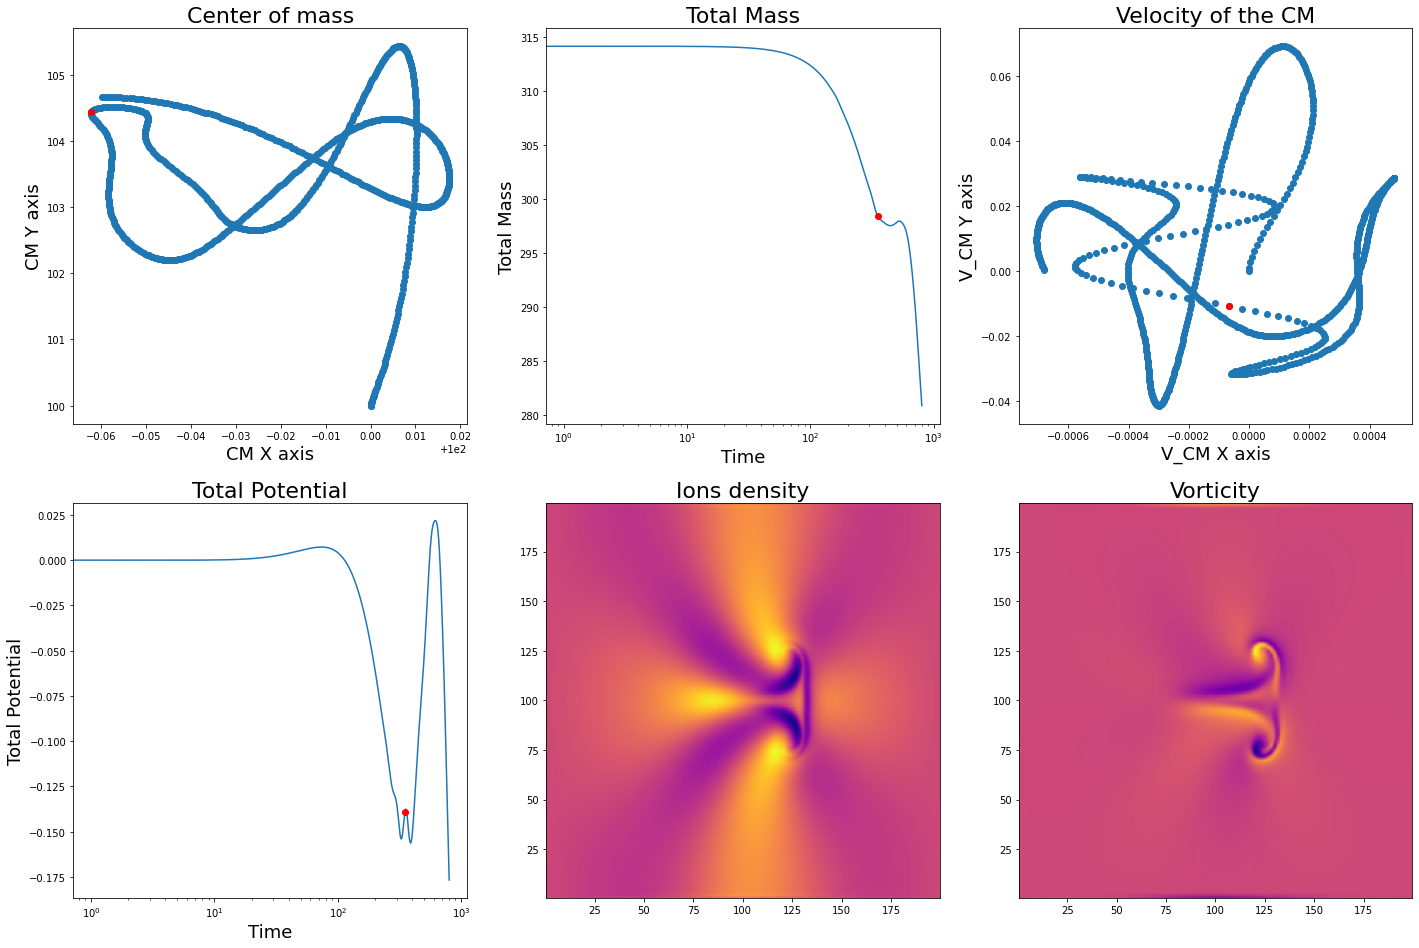

In [13]:
ftsz_title = 22
ftsz_label = 18

X, Y = np.meshgrid(Analitics.x, Analitics.y)

figure(figsize = (24, 16))

subplot(2, 3, 1);
plot(Analitics.X_CM, Analitics.Y_CM, 'o'); title('Center of mass', fontsize = ftsz_title)
plot(Analitics.X_CM[350], Analitics.Y_CM[350], 'o', color = 'red')
plt.xlabel('CM X axis', fontsize = ftsz_label)
plt.ylabel('CM Y axis', fontsize = ftsz_label)


subplot(2, 3, 2); 
plot(Analitics.time, Mass); title('Total Mass', fontsize = ftsz_title)
plot(Analitics.time[350], Mass[350], 'o', color = 'red')
plt.xlabel('Time', fontsize = ftsz_label)
plt.ylabel('Total Mass', fontsize = ftsz_label)
plt.xscale('log')


subplot(2, 3, 3); 
plot(Analitics.V_CM_x, Analitics.V_CM_y, 'o'); title('Velocity of the CM', fontsize = ftsz_title)
plot(Analitics.V_CM_x[350], Analitics.V_CM_y[350], 'o', color = 'red')
plt.xlabel('V_CM X axis', fontsize = ftsz_label)
plt.ylabel('V_CM Y axis', fontsize = ftsz_label)


subplot(2, 3, 4)
plot(Analitics.time, Potential); title('Total Potential', fontsize = ftsz_title)
plot(Analitics.time[350], Potential[350], 'o', color = 'red')
plt.xlabel('Time', fontsize = ftsz_label)
plt.ylabel('Total Potential', fontsize = ftsz_label)
plt.xscale('log')


subplot(2, 3, 5)
pcolormesh(Analitics.x, Analitics.y, Analitics.ions[350], cmap = 'plasma', shading = 'gouraud'); title('Ions density', fontsize = ftsz_title)

subplot(2, 3, 6)
pcolormesh(Analitics.x, Analitics.y, Analitics.Data['vorticity'][350], cmap = 'plasma', shading = 'gouraud'); title('Vorticity', fontsize = ftsz_title)

show()

In [14]:
for i in range(len(Mass)):
    if (Mass[0] - Mass[i]) / Mass[0] > 0.05:
        print(i)
        break

350


In [15]:
# print(Analitics.Data['energy_time'][:])

# print(Potential * (Analitics.x[-1] - Analitics.x[0]) ** 2)

print(np.dot(array(Analitics.Data['kinetic'][::10]), Potential))

-724.2483069696265
